In [1]:
! wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2021-12-11 21:14:27--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  52.8MB/s    in 15s     

2021-12-11 21:14:42 (48.3 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os import mkdir

mkdir("/content/Dataset/")
mkdir("/content/Dataset/UCSD/")

In [4]:
!tar -xzvf "/content/UCSD_Anomaly_Dataset.tar.gz" -C "/content/Dataset/UCSD" 

Streaming output truncated to the last 5000 lines.
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/139.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/002.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/060.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/085.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/067.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/127.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/131.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/012.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/148.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/144.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/015.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/009.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/102.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/143.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/078.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/017.bmp
UCSD_

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
from os import listdir, mkdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
class Config:
    DATASET_PATH ="/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    SINGLE_TEST_PATH = "/content/Dataset/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036"
    BATCH_SIZE = 4
    EPOCHS = 10
    MODEL_PATH = "/content/drive/MyDrive/Dataset/UCSD/Train/best_model.hdf5"
    MODEL1_PATH = "/content/drive/MyDrive/Dataset/UCSD/Train/best_model1.hdf5"
    SEQUENCE_SIZE = 10
    H = 256
    W = 256
    C = 1
    STRIDE = range(1, 3)
    TRAIN_SAMPLES_CSV_DIRECTORY = "/content/Dataset/UCSD/Train/npys"
    TRAIN_CSV_FILE = "/content/Dataset/UCSD/Train/train_df.csv"
    TEST_SAMPLES_CSV_DIRECTORY = "/content/Dataset/UCSD/Test/npys"
    TEST_CSV_FILE = "/content/Dataset/UCSD/Test/test_df.csv"



In [8]:
import shutil
 
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Train/")
# shutil.rmtree("/content/drive/MyDrive/Dataset/UCSD/Test/")

In [9]:
# shutil.rmtree("/content/Dataset/UCSD/Train/")
# shutil.rmtree("/content/Dataset/UCSD/Test/")

In [10]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Train/npys/")

In [11]:
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/")
# mkdir("/content/drive/MyDrive/Dataset/UCSD/Test/npys/")

In [12]:
mkdir("/content/Dataset/UCSD/Train/")
mkdir("/content/Dataset/UCSD/Train/npys/")

mkdir("/content/Dataset/UCSD/Test/")
mkdir("/content/Dataset/UCSD/Test/npys/")


In [13]:
def save_4D_sample_npy(sample, directory, index):
    file_name = "smaple{}.npy".format(index)
    file_path = join(directory, file_name)
    np.save(file_path, sample)
    return file_name

In [14]:
def load_npy_4D_sample(directory, file_name):
    file_path = join(directory, file_name)
    sample_data = np.load(file_path)
    #sample_data = sample_data.reshape((Config.SEQUENCE_SIZE, Config.H, Config.W, Config.C))
    return sample_data

In [15]:
# global sample_num 
# global smaple_number_list
# global smaple_file_name_list

In [16]:
sample_num = 0
smaple_number_list = []
smaple_file_name_list = []

In [17]:
def save_smaples_npy(sample, csv_files_directory):
    global sample_num 
    global smaple_number_list
    global smaple_file_name_list
    print(sample.shape, sample_num)
    sample_num += 1

    file_name = save_4D_sample_npy(sample, csv_files_directory, sample_num)
    smaple_number_list.append(sample_num)
    smaple_file_name_list.append(file_name)


In [18]:
def get_clips_by_stride(frames_list, stride, csv_files_directory,
                        sequence_size=Config.SEQUENCE_SIZE):
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, Config.H, Config.W, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                #clips.append(np.copy(clip))

                save_smaples_npy(clip, csv_files_directory)
                
                cnt = 0
    return np.array(clips)

In [19]:
def get_dataset(csv_files_directory):
    clips = []
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c).replace("\\", '/')
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((Config.H, Config.W))
                    img = np.array(img, dtype=np.float32) / 256.0
                    #img = np.array(img, dtype=np.float16) / 256.0
                    all_frames.append(img)
                    
            for st in Config.STRIDE:
                clips.extend(get_clips_by_stride(frames_list=all_frames, 
                                                 stride=st, 
                                                 csv_files_directory=csv_files_directory,
                                                 sequence_size=Config.SEQUENCE_SIZE))
    #return np.array(clips)

In [20]:
def reshape_dataset(dataset):
    return dataset.reshape(-1, Config.SEQUENCE_SIZE, Config.H, Config.W, 1)

In [21]:
#training_set = get_dataset(Config.TRAIN_SAMPLES_CSV_DIRECTORY)
#training_set = reshape_dataset(training_set)

get_dataset(Config.TRAIN_SAMPLES_CSV_DIRECTORY)

(10, 256, 256, 1) 0
(10, 256, 256, 1) 1
(10, 256, 256, 1) 2
(10, 256, 256, 1) 3
(10, 256, 256, 1) 4
(10, 256, 256, 1) 5
(10, 256, 256, 1) 6
(10, 256, 256, 1) 7
(10, 256, 256, 1) 8
(10, 256, 256, 1) 9
(10, 256, 256, 1) 10
(10, 256, 256, 1) 11
(10, 256, 256, 1) 12
(10, 256, 256, 1) 13
(10, 256, 256, 1) 14
(10, 256, 256, 1) 15
(10, 256, 256, 1) 16
(10, 256, 256, 1) 17
(10, 256, 256, 1) 18
(10, 256, 256, 1) 19
(10, 256, 256, 1) 20
(10, 256, 256, 1) 21
(10, 256, 256, 1) 22
(10, 256, 256, 1) 23
(10, 256, 256, 1) 24
(10, 256, 256, 1) 25
(10, 256, 256, 1) 26
(10, 256, 256, 1) 27
(10, 256, 256, 1) 28
(10, 256, 256, 1) 29
(10, 256, 256, 1) 30
(10, 256, 256, 1) 31
(10, 256, 256, 1) 32
(10, 256, 256, 1) 33
(10, 256, 256, 1) 34
(10, 256, 256, 1) 35
(10, 256, 256, 1) 36
(10, 256, 256, 1) 37
(10, 256, 256, 1) 38
(10, 256, 256, 1) 39
(10, 256, 256, 1) 40
(10, 256, 256, 1) 41
(10, 256, 256, 1) 42
(10, 256, 256, 1) 43
(10, 256, 256, 1) 44
(10, 256, 256, 1) 45
(10, 256, 256, 1) 46
(10, 256, 256, 1) 47
(1

In [22]:
train_df = pd.DataFrame(list(zip(smaple_number_list, smaple_file_name_list)),columns =['number', 'File name'])

train_df.to_csv(Config.TRAIN_CSV_FILE)

#del training_set

In [23]:
train_df = pd.read_csv(Config.TRAIN_CSV_FILE)

In [24]:
del sample_num 
del smaple_number_list 
del smaple_file_name_list 

In [25]:
sample_num = 0
smaple_number_list = []
smaple_file_name_list = []

In [26]:
#testing_set = get_dataset(Config.TEST_SAMPLES_CSV_DIRECTORY)
#testing_set = reshape_dataset(testing_set)

get_dataset(Config.TEST_SAMPLES_CSV_DIRECTORY)

(10, 256, 256, 1) 0
(10, 256, 256, 1) 1
(10, 256, 256, 1) 2
(10, 256, 256, 1) 3
(10, 256, 256, 1) 4
(10, 256, 256, 1) 5
(10, 256, 256, 1) 6
(10, 256, 256, 1) 7
(10, 256, 256, 1) 8
(10, 256, 256, 1) 9
(10, 256, 256, 1) 10
(10, 256, 256, 1) 11
(10, 256, 256, 1) 12
(10, 256, 256, 1) 13
(10, 256, 256, 1) 14
(10, 256, 256, 1) 15
(10, 256, 256, 1) 16
(10, 256, 256, 1) 17
(10, 256, 256, 1) 18
(10, 256, 256, 1) 19
(10, 256, 256, 1) 20
(10, 256, 256, 1) 21
(10, 256, 256, 1) 22
(10, 256, 256, 1) 23
(10, 256, 256, 1) 24
(10, 256, 256, 1) 25
(10, 256, 256, 1) 26
(10, 256, 256, 1) 27
(10, 256, 256, 1) 28
(10, 256, 256, 1) 29
(10, 256, 256, 1) 30
(10, 256, 256, 1) 31
(10, 256, 256, 1) 32
(10, 256, 256, 1) 33
(10, 256, 256, 1) 34
(10, 256, 256, 1) 35
(10, 256, 256, 1) 36
(10, 256, 256, 1) 37
(10, 256, 256, 1) 38
(10, 256, 256, 1) 39
(10, 256, 256, 1) 40
(10, 256, 256, 1) 41
(10, 256, 256, 1) 42
(10, 256, 256, 1) 43
(10, 256, 256, 1) 44
(10, 256, 256, 1) 45
(10, 256, 256, 1) 46
(10, 256, 256, 1) 47
(1

In [27]:
test_df = pd.DataFrame(list(zip(smaple_number_list, smaple_file_name_list)),columns =['number', 'File name'])

test_df.to_csv(Config.TEST_CSV_FILE)

#del testing_set

In [28]:
test_df = pd.read_csv(Config.TEST_CSV_FILE)

In [29]:
del sample_num 
del smaple_number_list 
del smaple_file_name_list 

In [30]:
import keras
import tensorflow as tf
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

In [31]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col, 
                 directory,
                 batch_size,
                 shuffle=False):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, file_name):
        image_arr = load_npy_4D_sample(self.directory, file_name)
        return image_arr
    
    def __get_data(self, batches):
        path_batch_x = batches[self.X_col]
        path_batch_y = batches[self.y_col]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch_x])
        Y_batch = np.asarray([self.__get_input(y) for y in path_batch_y])

        return X_batch, Y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [32]:
# import random 

# n = random.randint(0, len(train_df))
# randomlist = random.sample(range(0, len(train_df)), len(train_df)) 
# val_size = 0.1
# val_size = int(len(train_df) * val_size)
# val_size = randomlist[:val_size]
# validation_df = train_df.iloc[val_size]

validation_df = test_df

In [33]:
train_gen = CustomDataGen(train_df,
                          X_col="File name",
                          y_col="File name",
                          directory = Config.TRAIN_SAMPLES_CSV_DIRECTORY,
                          batch_size=Config.BATCH_SIZE,
                          shuffle=True)


validation_gen = CustomDataGen(validation_df,
                               X_col="File name",
                               y_col="File name",
                               directory = Config.TRAIN_SAMPLES_CSV_DIRECTORY,
                               batch_size=Config.BATCH_SIZE,
                               shuffle=True)

In [34]:
# from tensorflow.keras import mixed_precision

# policy = mixed_precision.experimental.Policy('mixed_float16')
# mixed_precision.experimental.set_policy(policy)


In [35]:
def build_model(optimizer="adam", loss="mse", reload_model=True):
    
    if not reload_model:
        return load_model(Config.MODEL_PATH)
    
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, Config.SEQUENCE_SIZE, Config.H, Config.W, 1)))
    model.add(LayerNormalization())
    
    model.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    model.add(LayerNormalization())

    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    
    model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())
    
    model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    model.add(LayerNormalization())

    model.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    model.add(LayerNormalization())
    
    model.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    model.add(LayerNormalization())
    
    model.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [36]:
optimizer = Adam(lr=1e-4, decay=1e-5, epsilon=1e-6)
loss = "mse"
model = build_model(optimizer, loss)
model.summary()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 64, 64, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 32, 32, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 32, 32, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    2

In [37]:
!pip install livelossplot

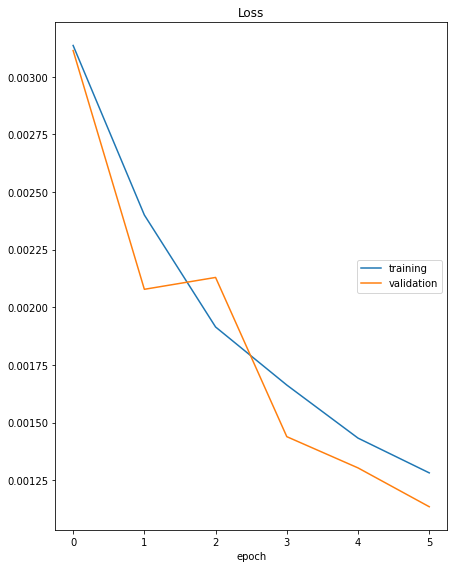

Loss
	training         	 (min:    0.001, max:    0.003, cur:    0.001)
	validation       	 (min:    0.001, max:    0.003, cur:    0.001)
340/340 [==============================] - 2988s 9s/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/10
106/340 [========>.....................] - ETA: 27:33 - loss: 0.0011

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

checkpoint = ModelCheckpoint(filepath=Config.MODEL_PATH, monitor="val_loss", verbose=1, save_best_only=True, mode="min", save_weights_only=True)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint, es, PlotLossesKeras()]#, lr_reduce]

history = None
with tf.device('/device:GPU:0'):
  history = model.fit(train_gen,
                    validation_data = validation_gen,
                    epochs=Config.EPOCHS, 
                    callbacks=callbacks, 
                    verbose=1)

In [38]:
 model.load_weights(Config.MODEL_PATH)


In [39]:
def get_single_test(test_file_path):
    sz = 200
    test = np.zeros(shape=(sz, Config.H, Config.W, 1))
    cnt = 0
    for f in sorted(listdir(test_file_path)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((Config.H, Config.W))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [40]:
def create_test_file_seq(test):
    print(test.shape)
    sz = test.shape[0] - Config.SEQUENCE_SIZE + 1
    sequences = np.zeros((sz, Config.SEQUENCE_SIZE, Config.H, Config.W, 1))
    for i in range(0, sz):
        clip = np.zeros((Config.SEQUENCE_SIZE, Config.H, Config.W, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("loaded data")
    return sequences

In [41]:
import matplotlib.pyplot as plt

def evaluate(sequences):    
    sz = sequences.shape[0] - Config.SEQUENCE_SIZE + 1
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)

    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    
    return sr, reconstructed_sequences

In [42]:
test = get_single_test(Config.SINGLE_TEST_PATH)
sequences = create_test_file_seq(test)

(200, 256, 256, 1)
loaded data


In [43]:
sr, reconstructed_sequences = evaluate(sequences)
sr

array([0.98590532, 0.9887513 , 0.9913477 , 0.99201546, 0.99249418,
       0.99322639, 0.99470596, 0.99521347, 0.99334469, 0.99087648,
       0.98818266, 0.98648901, 0.98350399, 0.98002143, 0.97736765,
       0.97552881, 0.97443631, 0.97438585, 0.97537342, 0.97464562,
       0.96977996, 0.96438211, 0.95711392, 0.95108477, 0.94792704,
       0.94188755, 0.93352003, 0.92418006, 0.91545625, 0.90805995,
       0.90282007, 0.89836002, 0.89264364, 0.8845191 , 0.8756509 ,
       0.87078794, 0.870481  , 0.86710562, 0.86927022, 0.87144082,
       0.87099453, 0.87090336, 0.87204083, 0.87228622, 0.87602436,
       0.87708148, 0.87747631, 0.8798788 , 0.87801201, 0.87613779,
       0.87778878, 0.87516589, 0.87489037, 0.87612435, 0.87666676,
       0.87557123, 0.87738793, 0.88001427, 0.88222279, 0.88385994,
       0.88436156, 0.88460716, 0.88507546, 0.88605571, 0.88657121,
       0.88540677, 0.88178025, 0.8763698 , 0.87355367, 0.87300061,
       0.87059913, 0.86936575, 0.86722893, 0.86397208, 0.86211

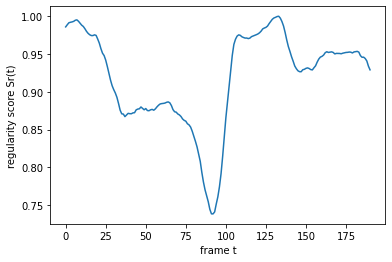

In [44]:
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [45]:
sequences[0].shape

(10, 256, 256, 1)

In [46]:
seq_num = 50

In [47]:
result = []
result.append(sequences[seq_num][0].reshape((Config.H, Config.W)))
result.append(reconstructed_sequences[seq_num][0].reshape((Config.H, Config.W)))
result = np.array(result)

In [48]:
result.shape

(2, 256, 256)

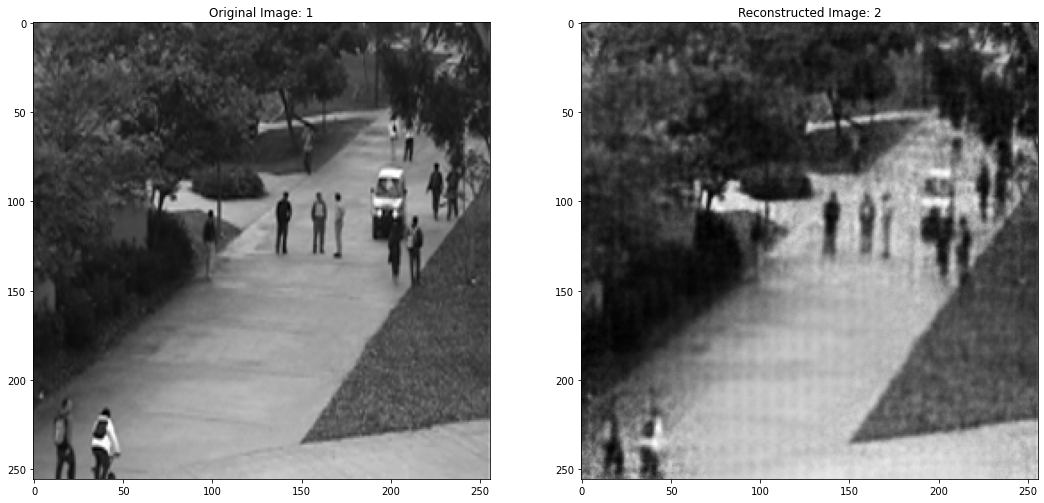

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(result[i], cmap="gray")
    if i % 2 == 0:
      plt.title('Original Image: {}'.format(i+1))
    else:
      plt.title('Reconstructed Image: {}'.format(i+1))

plt.show()

In [50]:
from scipy import signal
from PIL import Image

In [51]:
def fig2data(fig):
    fig.canvas.draw ( )
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    data = data.reshape((h, w, 3))
    return data

In [52]:
def plot(img, fig, axes,output, diff, H, threshold):
    (ax0, ax1, ax2,ax3) = axes
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    data = fig2data ( fig )
    return Image.fromarray(data)

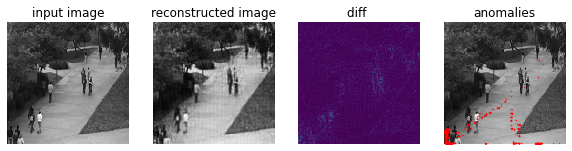

In [ ]:
threshold = 4*255
counter = 0

fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
frame_result = [] 

for seq, rec_seq in zip(sequences, reconstructed_sequences):
  for index in range(len(seq)):  
    counter = counter + 1
    img = np.array([seq[index]])
    output = np.array([rec_seq[index]])
    img = img*255
    output = output*255
    diff = np.abs(output-img)
  
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    res = plot(img[0,:,:,0], fig, (ax0, ax1, ax2,ax3), output[0,:,:,0], diff[0,:,:,0],
               H, threshold)
    
    frame_result.append(res)
    break

In [ ]:
frame_result[0].save("frames_result.gif", save_all=True, 
                      append_images=frame_result[1:], duration=100, loop=0)

In [53]:
class CustomDataGen1(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col, 
                 directory,
                 batch_size,
                 shuffle=False):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, file_name):
        image_arr = load_npy_4D_sample(self.directory, file_name)
        return image_arr
    
    def __get_data(self, batches):
        path_batch_x = batches[self.X_col]
        path_batch_y = batches[self.y_col]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch_x])
        Y_batch = np.asarray([self.__get_input(y) for y in path_batch_y])
        
        X_batch = np.transpose(X_batch, (0, 2, 3, 1, 4))
        Y_batch = np.transpose(Y_batch, (0, 2, 3, 1, 4))

        return X_batch, Y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [54]:
train_gen = CustomDataGen1(train_df,
                           X_col="File name",
                           y_col="File name",
                           directory = Config.TRAIN_SAMPLES_CSV_DIRECTORY,
                           batch_size=Config.BATCH_SIZE,
                           shuffle=True)


validation_gen = CustomDataGen1(validation_df,
                               X_col="File name",
                               y_col="File name",
                               directory = Config.TRAIN_SAMPLES_CSV_DIRECTORY,
                               batch_size=Config.BATCH_SIZE,
                               shuffle=True)

In [55]:
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose, Input, Lambda
from keras.models import Sequential

def build_model1(optimizer="adam", loss="mse", reload_model=True):
    
  if not reload_model:
    return load_model(Config.MODEL_PATH)

  model=Sequential()

  model.add(Input((Config.H,Config.W,Config.SEQUENCE_SIZE,Config.C)))

  model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

  model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

  model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

  model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))

  model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))

  model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='same',activation='tanh'))

  model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='same',activation='tanh'))

  model.compile(optimizer=optimizer,loss=loss)

  return model


In [56]:
model1 = build_model1()
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 64, 64, 10, 128)   15616     
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 10, 64)    204864    
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 32, 32, 10, 64)    295168    
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 32, 32, 10, 32)    110720    
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 32, 32, 10, 64)    221440    
                                                                 
 conv3d_transpose (Conv3DTra  (None, 64, 64, 10, 128)  204928    
 nspose)                                                         
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

checkpoint = ModelCheckpoint(filepath=Config.MODEL1_PATH, monitor="val_loss", verbose=1, save_best_only=True, mode="min", save_weights_only=True)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint, es, PlotLossesKeras()]#, lr_reduce]

history = None
with tf.device('/device:GPU:0'):
  history = model1.fit(train_gen,
                      validation_data = validation_gen,
                      epochs=Config.EPOCHS, 
                      callbacks=callbacks, 
                      verbose=1)

Epoch 1/10


In [ ]:
model1.load_weights(Config.MODEL1_PATH)

In [57]:
model1.load_weights("/content/drive/MyDrive/Dataset/UCSD/Train/best_model1 momen.hdf5")

In [85]:
def evaluate1(sequences):    
    sz = sequences.shape[0] - Config.SEQUENCE_SIZE + 1
    sequences = np.transpose(sequences, (0, 2, 3, 1, 4))
    reconstructed_sequences = model1.predict(sequences,batch_size=Config.BATCH_SIZE)

    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    
    return sr, reconstructed_sequences

In [86]:
test = get_single_test(Config.SINGLE_TEST_PATH)
sequences = create_test_file_seq(test)
sequences.shape

(200, 256, 256, 1)
loaded data


(191, 10, 256, 256, 1)

In [87]:
sr, reconstructed_sequences = evaluate1(sequences)
sr

array([0.99231713, 0.9948321 , 0.99779515, 0.99996745, 1.        ,
       0.99954422, 0.99934613, 0.99834521, 0.99595848, 0.99380651,
       0.9904386 , 0.98555437, 0.98048136, 0.97672367, 0.97312983,
       0.96942677, 0.96791742, 0.96852631, 0.96869827, 0.96777104,
       0.96353152, 0.95857544, 0.95127636, 0.94263126, 0.93535139,
       0.92357568, 0.9138708 , 0.90369185, 0.89310009, 0.88435742,
       0.87651983, 0.86968043, 0.86418931, 0.86146589, 0.85780689,
       0.8535346 , 0.85213398, 0.85352098, 0.85360211, 0.85258937,
       0.85087708, 0.85136613, 0.84994621, 0.85114394, 0.85118995,
       0.85169222, 0.84986528, 0.84821455, 0.84688603, 0.84407055,
       0.84325964, 0.84227634, 0.84030186, 0.8393216 , 0.8396492 ,
       0.84121366, 0.84413037, 0.84557106, 0.84507721, 0.8448181 ,
       0.84671684, 0.85031667, 0.84995554, 0.85012002, 0.84910723,
       0.84607213, 0.841808  , 0.83499693, 0.82844383, 0.82461799,
       0.81983863, 0.81618104, 0.810772  , 0.80639966, 0.80215

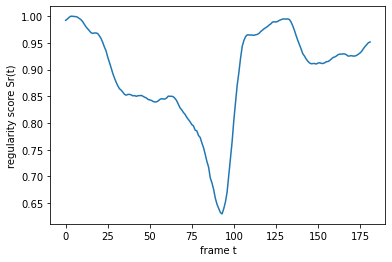

In [88]:
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [89]:
seq_num = 50

In [90]:
reconstructed_sequences.shape

(191, 256, 256, 10, 1)

In [91]:
reconstructed_sequences = np.transpose(reconstructed_sequences, (0, 3, 1, 2, 4))
reconstructed_sequences.shape

(191, 10, 256, 256, 1)

In [92]:
result = []
result.append(sequences[seq_num][0].reshape((Config.H, Config.W)))
result.append(reconstructed_sequences[seq_num][0].reshape((Config.H, Config.W)))
result = np.array(result)

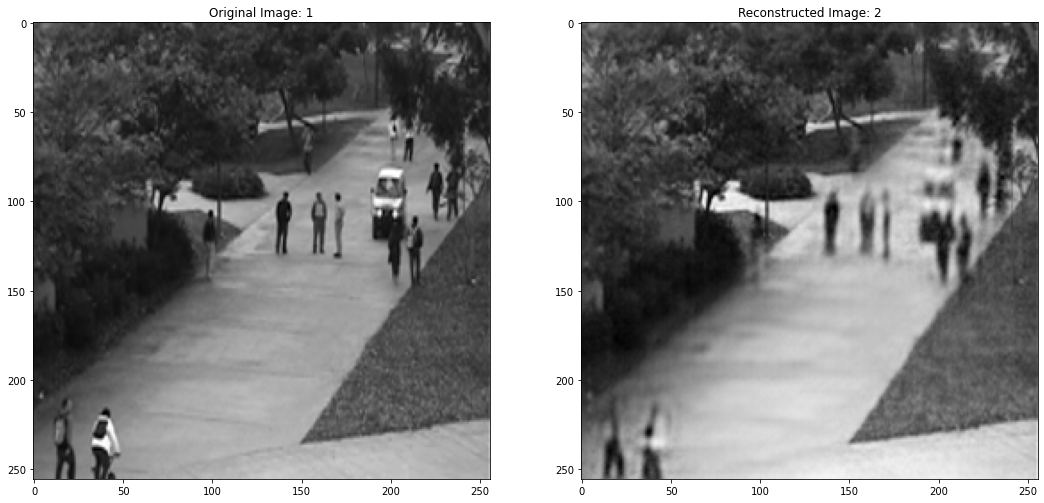

In [93]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(result[i], cmap="gray")
    if i % 2 == 0:
      plt.title('Original Image: {}'.format(i+1))
    else:
      plt.title('Reconstructed Image: {}'.format(i+1))

plt.show()

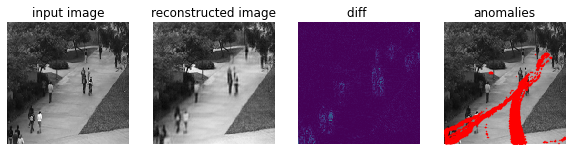

In [94]:
threshold = 4*255
counter = 0

fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
frame_result = [] 

for seq, rec_seq in zip(sequences, reconstructed_sequences):
  for index in range(len(seq)):  
    counter = counter + 1
    img = np.array([seq[index]])
    output = np.array([rec_seq[index]])
    img = img*255
    output = output*255
    diff = np.abs(output-img)
  
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')

    res = plot(img[0,:,:,0], fig, (ax0, ax1, ax2,ax3), output[0,:,:,0], diff[0,:,:,0],
               H, threshold)
    
    frame_result.append(res)
    break

In [95]:
frame_result[0].save("frames_result1.gif", save_all=True, 
                      append_images=frame_result[1:], duration=100, loop=0)